# Application of RNN on Multi-label Text Classification

Nowadays, internet becomes more than a huge platform for people to learn news, express their ideas and discuss with other netizens. The development and revolution of technology reduces the barrier to access the internet and more people are able to participate in online event and discussion. On the other hand, it also indirectly causes the arise of toxic comments and hate speech. Lots of threads and some famous forums were deactivated in the threat of harassment online and an improvement on maintaining a healthy internet environment becomes more important to encourage users actively expressing their thoughts. This study focused on discovering the performance of recurrent neural network (RNN) on the multi-label text classification. 159,571 Wikipedia Talk Page comments are fed to RNN for model training and hyperparameter tuning. Training and validation data set has 8 columns: id, comment_text and 6 types of toxicity. All data is provided by the Kaggle Jigsaw competition host, who pulled the data from Wikipedia Talk Page edit. The goal is to classify the validation data into the 6 types of toxicity (toxic, severe_toxic, obscene, threat	insult, identity_hate) as accurately as possible such that it's trustworthy for platforms to delete toxic comments and punish users who publish toxic posts accordingly. The optimized model is evaluated on the test set which contains 153,164 Wikipedia Talk Page comments and 2 columns - id and comment_text.

### Citation
cjadams, Jeffrey Sorensen, Julia Elliott, Lucas Dixon, Mark McDonald, nithum, Will Cukierski. (2017). Toxic Comment Classification Challenge. Kaggle. https://kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge

## Import Library

In [42]:
# import library
import warnings
#warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import os
import tensorflow as tf
import keras
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, RNN, LSTM, GRU, Dropout, Dense, Bidirectional
from keras.metrics import AUC
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from google.colab import drive

!pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

!pip install keras-tuner
import keras_tuner

## Setting Up Colab Environment

In this project, resources provided by Google Colab are utilized for training recurrent neural network and hyperparameter tuning. Zip files are copied to the Colab environment and unzip locally for faster access.

In [2]:
# setup Colab env.
drive.mount('/gdrive', force_remount = True)
train_data_path = '/gdrive/MyDrive/final_project/train.csv.zip'
test_data_path = '/gdrive/MyDrive/final_project/test.csv.zip'
test_label_path  ='/gdrive/MyDrive/final_project/test_labels.csv.zip'
sample_submission_path = '/gdrive/MyDrive/final_project/sample_submission.csv.zip'

local_path = '/content'
!cp '{train_data_path}' .
!cp '{test_data_path}' .
!cp '{test_label_path}' .
!cp '{sample_submission_path}' .

os.chdir(local_path)
!unzip -q 'train.csv.zip' -d '/content/data/'
!unzip -q 'test.csv.zip' -d '/content/data/'
!unzip -q 'test_labels.csv.zip' -d '/content/data/'
!unzip -q 'sample_submission.csv.zip' -d '/content/data/'

Mounted at /gdrive


## Data Cleansing and Exploratory Data Analysis

Before fitting the model, it is necessary to explore the training and test set to gain basic understanding of the data and discover hidden patterns. In this section, different statistical methods are leveraged to check missing value, duplicated records, data leakage as well as class and word frequency distributions.

In [3]:
# load data
wiki_train = pd.read_csv(os.path.join(local_path, 'data', 'train.csv'))
wiki_test = pd.read_csv(os.path.join(local_path, 'data', 'test.csv'))
wiki_test_label = pd.read_csv(os.path.join(local_path, 'data', 'test_labels.csv'))
wiki_sample_submission = pd.read_csv(os.path.join(local_path, 'data', 'sample_submission.csv'))

In [4]:
wiki_train.head(n = 10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
wiki_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
wiki_train_c = wiki_train.drop(['id'], axis = 1)
wiki_train_c.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Training data contains 159,571 comments and 8 columns: id, comment_text, toxic, severe_toxic, obscene, threat insult and identity_hate. Each comment may tag with more than one types of toxicity and the text contains ascii characters as expected. ID and comment_text columns have object data type while the six toxicity classes are integers. All columns have desired data types and no further cleansing is needed. There is no presence of null or missing values as well. Besides, ID is not required for model training or hyperparameter tuning; thus, ID is removed from training data.

In [7]:
wiki_test.head(n = 10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [8]:
wiki_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [9]:
wiki_sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [10]:
# wiki_test_label.head()

In [11]:
# remove ids in wiki_test_label from wiki_test
# wiki_test_c = wiki_test[~wiki_test.id.isin(wiki_test_label[wiki_test_label['toxic'] == -1]['id'])]
# wiki_test_c.head()

In [12]:
# wiki_test_c.info()

Test data contains 153,164 comments and 2 columns - id, comment_text. Both columns have desired string data type and no additional cleansing is required. Comment_text data will be used for prediction and ID data is needed to differentiate comments; thus, both columns are kept. Similar to the training data, comment_text in test data contains ascii characters and there is no presence of missing values.

In [13]:
## check duplication
wiki_train_c[wiki_train_c.duplicated()]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [14]:
wiki_test[wiki_test.duplicated()]

,id,comment_text


In [15]:
# check data leakage
wiki_full = wiki_train_c.assign(dataset_ind = np.repeat('train', wiki_train_c.shape[0])).append(wiki_test.assign(dataset_ind = np.repeat('test', wiki_test.shape[0])), ignore_index = True).drop(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1)
print(wiki_full[wiki_full.duplicated(keep = False)].to_string())

Empty DataFrame
Columns: [comment_text, dataset_ind]
Index: []


Both training data and test data don't contain duplicated records. Additionally, they don't share any comments in common, which will prevent models be suffering from data leakage problem.

Text(0, 0.5, 'Number of comments')

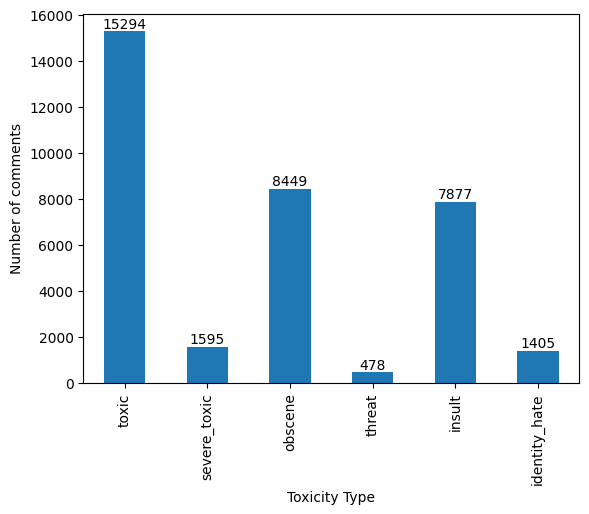

In [16]:
## check class distribution
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
ax = wiki_train_c[labels].apply(pd.Series.value_counts).iloc[1,:].plot(kind = 'bar')
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.set_xlabel('Toxicity Type')
ax.set_ylabel('Number of comments')

Above bar plot shows that 15,294 comments are tagged with 'toxic' which is the largest class. On the contrast, only 478 comments are tagged with 'threat'. The huge gap is a sign of class imbalance problem. Common methods to handle this issue includes but not limited to resampling and the use of weighted loss function. Considering the training data is large and the resources are relatively limited, the latter method is applied instead of oversampling minority classes in this project.

In [17]:
# count number of words of each comment
num_words = pd.DataFrame(wiki_train_c['comment_text'].str.split().str.len())
num_words.sort_values(by = 'comment_text', ascending = False).head()

,comment_text
140904,1411
4712,1403
81295,1354
35817,1344
136531,1250


Choose max_len as 1600.

In [18]:
# count word frequency
def word_freq_df(dataset):
    output = pd.DataFrame(dataset['comment_text'].str.split().explode().value_counts().reset_index())
    output = output.rename(columns = {'index': 'word', 'comment_text': 'freq'})
    return output

word_freq_train = word_freq_df(wiki_train_c)
word_freq_test = word_freq_df(wiki_test)

In [19]:
word_freq_train.sort_values(by = 'freq', ascending = False).head(n = 10)

,word,freq
0,the,445987
1,to,288817
2,of,219334
3,and,207381
4,a,201817
5,I,183930
6,is,164639
7,you,157272
8,that,140545
9,in,130262


In [20]:
word_freq_test.sort_values(by = 'freq', ascending = False).head(n = 10)

,word,freq
0,the,374881
1,to,234088
2,of,180682
3,a,177396
4,and,169295
5,is,144914
6,I,134728
7,you,120685
8,that,116021
9,in,110869


<Axes: >

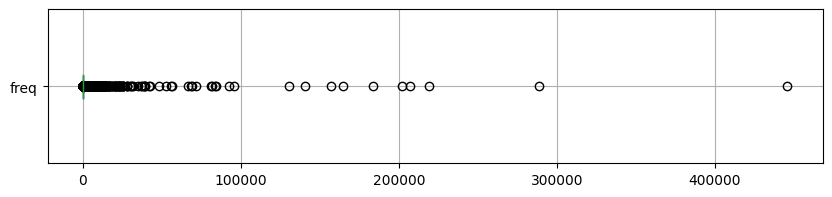

In [21]:
word_freq_train.boxplot(column = 'freq', vert = False, figsize = (10, 2))

The longest comment text contains approximately 1,411 words and most of the words appear less than 50,000 times. This information will be useful for word embedding in later steps. In additional, training set and test set have similar distribution with regard to the word frequency, which is a good sign. Besides, all top 10 words are English stop words which have little semantic meanings. Nonetheless, there is no need to remove them for training word vectors using word embedding method such as GloVe since they still contribute to the contextual meaning of a sentence.

In this section, training data has been cleaned by removing unnecessary columns. Toxicity class is found to have an imbalanced distribution and two techniques will be implemented to handle this issue. The training data will be further split into a new training set and validation set with stratified splitting technique to ensure validation set has a similar class distribution with training set. Otherwise, some minority classes may be missing from the training or validation set. Besides, the model will be trained with a weighted binary cross entropy function to handle this issue. That means, minority classes will be assigned larger weights to make the model less favor majority classes. Information regarding word frequency and appearance is further collected for word embedding. Resources are relatively limited compared with the data size and some techniques may be necessary to improve the efficiency of training process, e.g. adjusting batch size and learning rate.

## Text Data Preprocessing and Word Embedding

Before training the model, the representation of words is necessary to be transformed into the form of real value numeric vectors such that words that have similar meanings are closer to each other in the vector space. This technique is called word embedding and it's generally lumped into the field of natural language processing. However, training a custom word embedding is very resource-intensive. In this study, a pre-trained word embedding called Global Vector for Word Representation (GloVe) is leveraged to generate real value word vectors. The matrix composed of word vectors is actually the weight matrix of embedding layer and its output will be the input of RNN layers. This technique is called transfer learning.

Training data is further split into a new training set and test set in a stratified manner, and test set contains 20% of the comments.

In [22]:
# Stratified Train-val split
random.seed(42)
X = wiki_train_c['comment_text']
y = wiki_train_c.drop(['comment_text'], axis = 1)
X_train, y_train, X_val, y_val = iterative_train_test_split(np.vstack(X.to_numpy()), y.to_numpy(), test_size = 0.2)

In [23]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (127656, 1)
Shape of y_train: (127656, 6)
Shape of X_val: (31915, 1)
Shape of y_val: (31915, 6)


It's required to tokenize and clean sentences prior to the implementation of word embedding. General text cleansing technique include converting all words to lower case, removing special characters and vectorization. Keras Tokenizer class will be utilized to achieve all above tasks. Maximum number of words with respect to frequency (num_words) is set to 50,000 to cover most of the words in our corpus since most of the words appear less than 50,000 times based on earlier exploratory analysis. In addition, it's crucial to pad sequences to the same length since sentence sequences will have different length and RNN requires the input to have the uniform size. The maximum length is set to 1,600 such that the sequence that has length over than 1,600 will be truncated and sequence that's shorted will be padded by 0 in the front. Pre-padding is generally more favored over past-padding on text classification since RNN usually takes the final hidden state for prediction.

In [24]:
# data preprocessing
## tokenize sentiments
## convert words to lower case
## remove special characters
X_train_f = X_train.flatten()
X_val_f = X_val.flatten()

token = Tokenizer(num_words = 50000, oov_token = 'oov')
token.fit_on_texts(X_train_f)
def word_processing(data, max_len):
    data_seq = token.texts_to_sequences(data)
    data_seq_padded = pad_sequences(data_seq, maxlen = max_len, padding = 'pre', truncating = 'pre')
    print('Before padding example1', data_seq[0], '\n'
          'After padding example1', data_seq_padded[0], '\n'
          'Before padding example2', data_seq[1], '\n'
          'After padding example2', data_seq_padded[1])
    return data_seq_padded

In [25]:
max_len = 1600
X_train_seq_padded = word_processing(X_train_f, max_len = max_len)
X_val_seq_padded = word_processing(X_val_f, max_len = max_len)

Before padding example1 [684, 76, 2, 126, 130, 179, 29, 678, 4939, 12941, 1295, 87, 333, 52, 2329, 10919, 51, 7147, 16, 62, 2663, 146, 8, 3044, 35, 117, 1168, 14829, 2822, 5, 46, 60, 242, 2, 375, 32, 2, 38, 28, 145, 74, 3496, 90, 3055, 4421, 2234, 1061] 
After padding example1 [   0    0    0 ... 4421 2234 1061] 
Before padding example2 [1, 53, 2600, 14, 568, 3761, 74, 4940, 2770, 22, 94, 38, 795, 2722, 1012, 599, 8697, 183] 
After padding example2 [   0    0    0 ...  599 8697  183]
Before padding example1 [396, 40, 9, 12, 38, 40, 9, 12, 31, 4163, 424, 4, 62, 116, 1, 63, 20, 99, 35, 5323, 546, 4192, 1, 63, 3684, 77, 56, 49, 63, 5364, 89, 234, 16733, 92, 565, 1166, 5, 5632, 284, 1236, 35, 116, 209, 1, 3, 1486, 77, 67, 914, 95, 262, 37, 6787, 1217] 
After padding example1 [   0    0    0 ...   37 6787 1217] 
Before padding example2 [133, 21, 7190, 1114, 11, 2, 384, 5507] 
After padding example2 [   0    0    0 ...    2  384 5507]


In [26]:
# word embedding - GloVe
glove_path = '/gdrive/MyDrive/final_project/glove.6B.zip'
!cp {glove_path} .
!unzip -q glove.6B.zip -d '/content/glove/'

In [27]:
word_vec_len = 100

def glove_embedding(word_vec_len):
    glove_path = os.path.join(local_path, 'glove', 'glove.6B.' + str(word_vec_len) + 'd.txt')
    embeddings_index = {}
    with open(glove_path) as f:
        for line in f:
           word, coeffs = line.split(' ', maxsplit = 1)
           coeffs = np.fromstring(coeffs, dtype = 'float32', sep = ' ')
           embeddings_index[word] = coeffs

    word_index = token.word_index
    embeddings_matrix = np.zeros((len(word_index) + 1, word_vec_len))
    for word, index in word_index.items():
        embedding_vec = embeddings_index.get(word)
        if embedding_vec is not None:
            embeddings_matrix[index] = embedding_vec
    return word_index, embeddings_matrix


word_index, embeddings_matrix = glove_embedding(100)

Now, training and validation set is prepared for training the neural network. Embeddings weight matrix has been generated as well.

## Recurrent Neural Network

In this section, different architectures of RNN are designed and trained with weighted binary cross entropy function. By evaluating the model performance at each epochs during the training process, it's easier for us to improve the model through an iterative process to either improve the performance or handling potential issues like overfitting. Besides, hyperparameters are tuned with random search method to find the optimized model once the architecture is determined.

In [28]:
# define weighted Binary Cross Entropy
p_weights = []
n_weights = []

for i in range(len(labels)):
    p_weights.append(y_train.shape[0] / (2 * np.count_nonzero(y_train[:, i] == 1)))
    n_weights.append(y_train.shape[0] / (2 * np.count_nonzero(y_train[:, i] == 0)))

p_weights = np.array(p_weights)
n_weights = np.array(n_weights)
print(p_weights)
print(n_weights)

def weighted_BCE(y_true, y_pred):
    #tmp = np.mean(p_weights * y_true * K.log(y_pred) + n_weights * (1 - y_true) * K.log(1 - y_pred))
    loss = 0
    for i in range(len(labels)):
        loss += p_weights[i] * y_true[i] * K.log(y_pred[i]) + n_weights[i] * (1 - y_true[i]) * K.log(1 - y_pred[i])
    #tmp = np.mean(loss)
    return -loss

[  5.21683694  50.02194357   9.44340879 167.08900524  10.12821327
  56.78647687]
[0.55300162 0.50504827 0.52795355 0.5015007  0.52596536 0.50444156]


In [29]:
# performance plot function
def perform_plot(epochs, his):
    f, ax = plt.subplots(1, 3, figsize = (15, 3))
    ax[0].plot(range(1, epochs + 1), his['loss'], label = 'Training loss')
    ax[0].plot(range(1, epochs + 1), his['val_loss'], label = 'Validation loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[1].plot(range(1, epochs + 1), his['accuracy'], label = 'Training accuracy')
    ax[1].plot(range(1, epochs + 1), his['val_accuracy'], label = 'Validation accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    ax[2].plot(range(1, epochs + 1), his['auc'], label = 'Training AUC')
    ax[2].plot(range(1, epochs + 1), his['val_auc'], label = 'Validation AUC')
    ax[2].legend()
    ax[2].set_title('Average AUC')

A baseline RNN with three layers - embedding layer, LSTM layer, output layer - is trained with a weighted loss function initially and its performance is treated as a benchmark. The value of loss function and AUC metric at each epoch will be used for checking overfitting/ underfitting problem and performance evaluation.

In [ ]:
# Baseline model
model_base = Sequential()
model_base.add(Embedding(input_dim = len(word_index) + 1, output_dim = word_vec_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model_base.add(LSTM(64))
model_base.add(Dense(6, activation = 'sigmoid'))

model_base.compile(optimizer = 'adam', loss = weighted_BCE, metrics = ['accuracy', AUC(name = 'auc', multi_label = True, num_labels = 6)])
model_base.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 1600, 100)         18266100  
                                                                 
 lstm_29 (LSTM)              (None, 64)                42240     
                                                                 
 dense_25 (Dense)            (None, 6)                 390       
                                                                 
Total params: 18308730 (69.84 MB)
Trainable params: 42630 (166.52 KB)
Non-trainable params: 18266100 (69.68 MB)
_________________________________________________________________


In [ ]:
hist_base = model_base.fit(X_train_seq_padded, y_train.astype('float32'), epochs = 10, validation_data = (X_val_seq_padded, y_val.astype('float32')))

Epoch 1/10
3990/3990 [==============================] - 187s 46ms/step - loss: 3.5886 - accuracy: 0.9751 - auc: 0.8979 - val_loss: 2.5899 - val_accuracy: 0.9920 - val_auc: 0.9567
Epoch 2/10
3990/3990 [==============================] - 186s 47ms/step - loss: 2.4495 - accuracy: 0.9860 - auc: 0.9514 - val_loss: 2.3736 - val_accuracy: 0.9868 - val_auc: 0.9649
Epoch 3/10
3990/3990 [==============================] - 181s 45ms/step - loss: 2.3537 - accuracy: 0.9768 - auc: 0.9597 - val_loss: 2.1655 - val_accuracy: 0.9834 - val_auc: 0.9660
Epoch 4/10
3990/3990 [==============================] - 183s 46ms/step - loss: 2.1744 - accuracy: 0.9694 - auc: 0.9649 - val_loss: 2.4158 - val_accuracy: 0.9744 - val_auc: 0.9687
Epoch 5/10
3990/3990 [==============================] - 183s 46ms/step - loss: 2.1568 - accuracy: 0.9761 - auc: 0.9683 - val_loss: 1.9342 - val_accuracy: 0.9750 - val_auc: 0.9730
Epoch 6/10
3990/3990 [==============================] - 182s 46ms/step - loss: 1.9589 - accuracy: 0.9766 

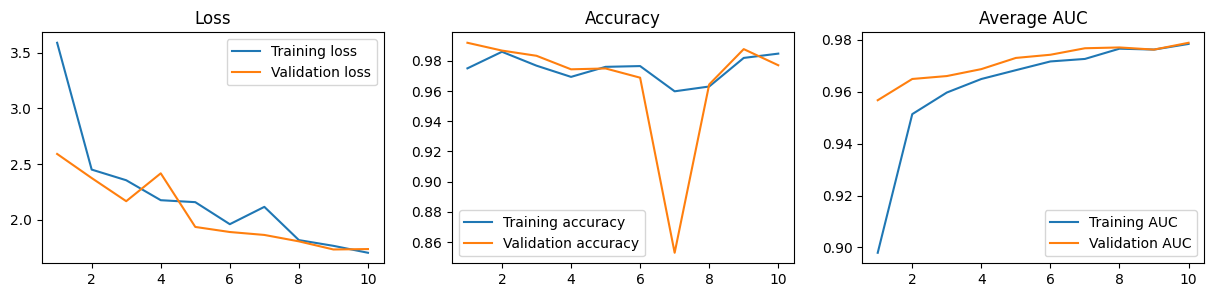

In [ ]:
perform_plot(10, hist_base.history)

The baseline model has a decent performance with respect to Average AUC. During the training process, the training loss is higher than the validation loss at all epochs except the fourth and the last one, which is a sign of underfitting. One possible reason is that the training loss is measured around half an epoch earlier than the validation loss. Indeed, training loss will be closer to the validation loss by shifting it half an epoch to the left. Another potential reason is that the validation set is less challenging than the training set and the fact that validation average AUC is almost always higher than the training average AUC provides some evidence of this hypothesis. A dropout layer will be inserted in the beginning of the current model to reduce underfitting. Additionally, the model takes around 30 minutes to be finished training and a larger batch size will be used to accelerate the training process. A more efficient training process is beneficial for our learning process.

In [ ]:
# add dropout layer
model2 = Sequential()
model2.add(Embedding(input_dim = len(word_index) + 1, output_dim = word_vec_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model2.add(LSTM(130))
model2.add(Dropout(0.2))
model2.add(Dense(6, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = weighted_BCE, metrics = ['accuracy', AUC(name = 'auc', multi_label = True, num_labels = 6)])
model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 1600, 100)         18266100  
                                                                 
 lstm_30 (LSTM)              (None, 130)               120120    
                                                                 
 dropout_26 (Dropout)        (None, 130)               0         
                                                                 
 dense_26 (Dense)            (None, 6)                 786       
                                                                 
Total params: 18387006 (70.14 MB)
Trainable params: 120906 (472.29 KB)
Non-trainable params: 18266100 (69.68 MB)
_________________________________________________________________


In [ ]:
hist2 = model2.fit(X_train_seq_padded, y_train.astype('float32'), epochs = 10, batch_size = 128, validation_data = (X_val_seq_padded, y_val.astype('float32')))

Epoch 1/10
998/998 [==============================] - 113s 111ms/step - loss: 5.4924 - accuracy: 0.8320 - auc: 0.7018 - val_loss: 5.2454 - val_accuracy: 0.9937 - val_auc: 0.7989
Epoch 2/10
998/998 [==============================] - 110s 110ms/step - loss: 4.2105 - accuracy: 0.9531 - auc: 0.8667 - val_loss: 3.6257 - val_accuracy: 0.9929 - val_auc: 0.9413
Epoch 3/10
998/998 [==============================] - 109s 109ms/step - loss: 2.9217 - accuracy: 0.9791 - auc: 0.9305 - val_loss: 3.3495 - val_accuracy: 0.9810 - val_auc: 0.9521
Epoch 4/10
998/998 [==============================] - 109s 109ms/step - loss: 2.8805 - accuracy: 0.9617 - auc: 0.9411 - val_loss: 3.2103 - val_accuracy: 0.9917 - val_auc: 0.9568
Epoch 5/10
998/998 [==============================] - 110s 111ms/step - loss: 2.7414 - accuracy: 0.9783 - auc: 0.9346 - val_loss: 4.0277 - val_accuracy: 0.9915 - val_auc: 0.9538
Epoch 6/10
998/998 [==============================] - 110s 110ms/step - loss: 2.7074 - accuracy: 0.9735 - auc:

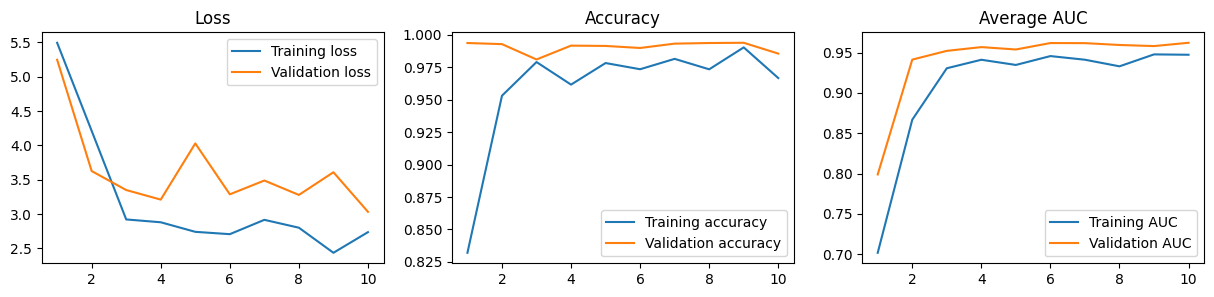

In [ ]:
perform_plot(10, hist2.history)

Training time dropped significantly by increasing batch size from 32 to 128. Averaged AUC decreases slighted as expected since a larger batch size has a negative impact on model performance; however, the performance is still acceptable. In addition, the underfitting issue is significantly improved by the introduction of dropout layer, which is clearly illustrated by the loss plot. In the next step, a bidirectional LSTM will be trained to aim for improving the model performance. A bidirectional LSTM consists of two LSTM layers, one processes sequencies in the forward direction and another one processes in the backward direction. The design allows it to capture richer dependencies in the text data and it's expected to result in a better performance than a regular LSTM in our study.

In [ ]:
# Bidirectional LSTM
model3 = Sequential()
model3.add(Embedding(input_dim = len(word_index) + 1, output_dim = word_vec_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model3.add(Bidirectional(LSTM(130)))
model3.add(Dropout(0.2))
model3.add(Dense(6, activation = 'sigmoid'))

model3.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy', tf.keras.metrics.F1Score(average = 'weighted'), AUC(name = 'auc', multi_label = True, num_labels = 6)])
model3.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 1600, 100)         18266100  
                                                                 
 bidirectional_9 (Bidirecti  (None, 260)               240240    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 260)               0         
                                                                 
 dense_28 (Dense)            (None, 6)                 1566      
                                                                 
Total params: 18507906 (70.60 MB)
Trainable params: 241806 (944.55 KB)
Non-trainable params: 18266100 (69.68 MB)
_________________________________________________________________


In [ ]:
hist3 = model3.fit(X_train_seq_padded, y_train.astype('float32'), epochs = 10, batch_size = 128, validation_data = (X_val_seq_padded, y_val.astype('float32')))

Epoch 1/10
998/998 [==============================] - 225s 222ms/step - loss: 0.0783 - accuracy: 0.9345 - f1_score: 0.0870 - auc: 0.9110 - val_loss: 0.0582 - val_accuracy: 0.9940 - val_f1_score: 0.0762 - val_auc: 0.9596
Epoch 2/10
998/998 [==============================] - 221s 221ms/step - loss: 0.0574 - accuracy: 0.9890 - f1_score: 0.0772 - auc: 0.9535 - val_loss: 0.0533 - val_accuracy: 0.9936 - val_f1_score: 0.0770 - val_auc: 0.9625
Epoch 3/10
998/998 [==============================] - 221s 221ms/step - loss: 0.0525 - accuracy: 0.9903 - f1_score: 0.0808 - auc: 0.9625 - val_loss: 0.0534 - val_accuracy: 0.9936 - val_f1_score: 0.0767 - val_auc: 0.9739
Epoch 4/10
998/998 [==============================] - 221s 221ms/step - loss: 0.0487 - accuracy: 0.9896 - f1_score: 0.0838 - auc: 0.9715 - val_loss: 0.0489 - val_accuracy: 0.9935 - val_f1_score: 0.0767 - val_auc: 0.9717
Epoch 5/10
998/998 [==============================] - 221s 221ms/step - loss: 0.0460 - accuracy: 0.9866 - f1_score: 0.08

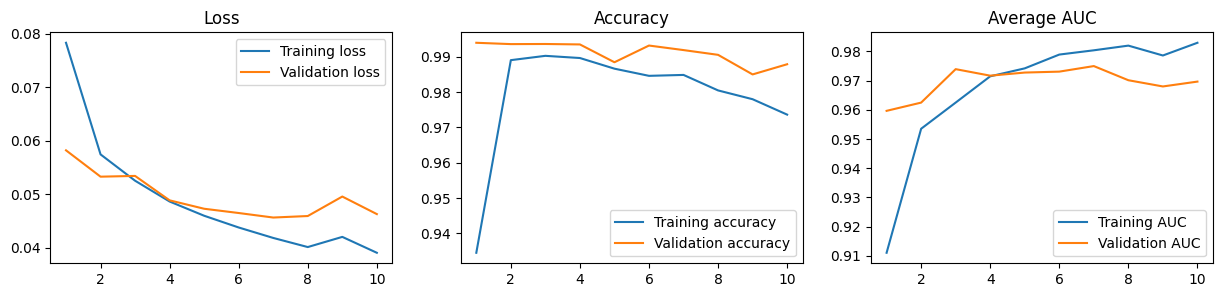

In [ ]:
perform_plot(10, hist3.history)

The bidirectional LSTM model has a lower validation loss and higher average validation AUC than the previous LSTM neural network. However, it also has a much longer training time which indicates a trade-off between model performance and training efficiency.

In [ ]:
# GRU
model4 = Sequential()
model4.add(Embedding(input_dim = len(word_index) + 1, output_dim = word_vec_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model4.add(GRU(130))
model4.add(Dropout(0.2))
model4.add(Dense(6, activation = 'sigmoid'))

model4.compile(optimizer = 'adam', loss = weighted_BCE, metrics = ['accuracy', tf.keras.metrics.F1Score(average = 'micro'), AUC(name = 'auc', multi_label = True, num_labels = 6)])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1600, 100)         18281500  
                                                                 
 gru (GRU)                   (None, 130)               90480     
                                                                 
 dropout (Dropout)           (None, 130)               0         
                                                                 
 dense (Dense)               (None, 6)                 786       
                                                                 
Total params: 18372766 (70.09 MB)
Trainable params: 91266 (356.51 KB)
Non-trainable params: 18281500 (69.74 MB)
_________________________________________________________________


In [ ]:
hist4 = model4.fit(X_train_seq_padded, y_train.astype('float32'), epochs = 10, batch_size = 128, validation_data = (X_val_seq_padded, y_val.astype('float32')))

Epoch 1/10
998/998 [==============================] - 102s 97ms/step - loss: 4.6574 - accuracy: 0.8608 - f1_score: 0.1467 - auc: 0.8208 - val_loss: 4.3819 - val_accuracy: 0.9915 - val_f1_score: 0.1566 - val_auc: 0.9302
Epoch 2/10
998/998 [==============================] - 100s 101ms/step - loss: 3.0713 - accuracy: 0.9019 - f1_score: 0.1526 - auc: 0.9312 - val_loss: 3.1749 - val_accuracy: 0.9650 - val_f1_score: 0.1529 - val_auc: 0.9562
Epoch 3/10
998/998 [==============================] - 100s 101ms/step - loss: 2.9582 - accuracy: 0.8810 - f1_score: 0.1469 - auc: 0.9337 - val_loss: 3.0594 - val_accuracy: 0.9904 - val_f1_score: 0.1560 - val_auc: 0.9530
Epoch 4/10
998/998 [==============================] - 100s 101ms/step - loss: 2.7358 - accuracy: 0.9200 - f1_score: 0.1515 - auc: 0.9492 - val_loss: 2.6478 - val_accuracy: 0.8168 - val_f1_score: 0.1548 - val_auc: 0.9634
Epoch 5/10
998/998 [==============================] - 100s 101ms/step - loss: 2.3073 - accuracy: 0.8481 - f1_score: 0.150

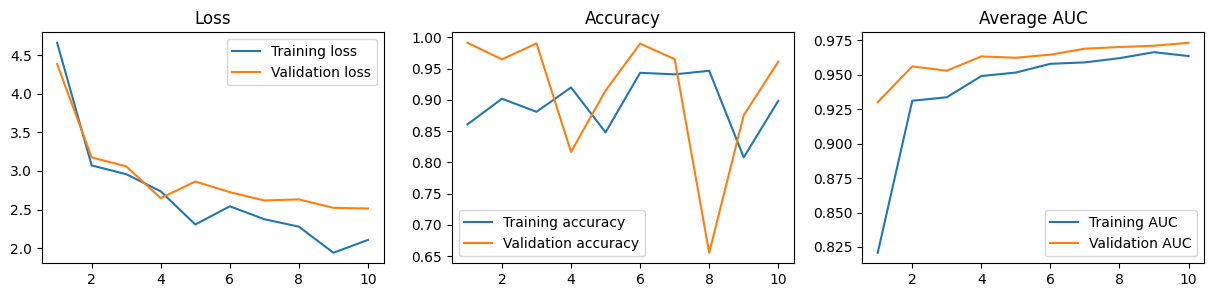

In [ ]:
perform_plot(10, hist4.history)

Theoretically, the performance of GRU is comparable to their LSTM counterparts but computationally more efficient since GRU unit has less gates. Above performance plots illustrate that the performance of GRU is on par with LSTM and it took less time to training the model at each epoch. Next, a stacked RNN will be trained to further improve the AUC score.

In [ ]:
# Stacked RNN
model5 = Sequential()
model5.add(Embedding(input_dim = len(word_index) + 1, output_dim = word_vec_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model5.add(Bidirectional(GRU(130, return_sequences = True)))
model5.add(Dropout(0.2))
model5.add(Bidirectional(GRU(130)))
model5.add(Dropout(0.2))
model5.add(Dense(6, activation = 'sigmoid'))

model5.compile(optimizer = 'adam', loss = weighted_BCE, metrics = ['accuracy', AUC(name = 'auc', multi_label = True, num_labels = 6)])
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1600, 100)         18281500  
                                                                 
 bidirectional_2 (Bidirecti  (None, 1600, 260)         180960    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 1600, 260)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 260)               305760    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 260)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                

In [ ]:
hist5 = model5.fit(X_train_seq_padded, y_train.astype('float32'), epochs = 10, batch_size = 128, validation_data = (X_val_seq_padded, y_val.astype('float32')))

Epoch 1/10
998/998 [==============================] - 507s 502ms/step - loss: 4.5394 - accuracy: 0.7398 - auc: 0.8028 - val_loss: 3.7931 - val_accuracy: 0.9528 - val_auc: 0.9501
Epoch 2/10
998/998 [==============================] - 499s 500ms/step - loss: 3.4633 - accuracy: 0.8459 - auc: 0.9195 - val_loss: 3.9414 - val_accuracy: 0.4425 - val_auc: 0.9461
Epoch 3/10
998/998 [==============================] - 499s 500ms/step - loss: 2.4791 - accuracy: 0.9118 - auc: 0.9385 - val_loss: 3.9745 - val_accuracy: 0.9835 - val_auc: 0.9468
Epoch 4/10
998/998 [==============================] - 500s 501ms/step - loss: 3.1589 - accuracy: 0.8484 - auc: 0.9361 - val_loss: 2.8820 - val_accuracy: 0.7446 - val_auc: 0.9614
Epoch 5/10
998/998 [==============================] - 501s 502ms/step - loss: 2.6720 - accuracy: 0.8548 - auc: 0.9408 - val_loss: 4.2463 - val_accuracy: 0.9834 - val_auc: 0.9590
Epoch 6/10
998/998 [==============================] - 502s 503ms/step - loss: 2.4389 - accuracy: 0.9219 - auc:

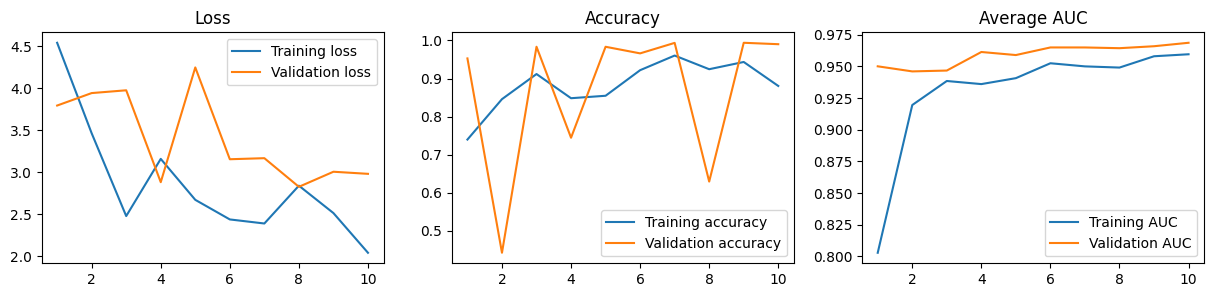

In [ ]:
perform_plot(10, hist5.history)

Stacked RNN consists of multiple RNN layers on top of each other, which combines the advantages of deep learning and recurrent learning. In theory, the stacking allows the neural network to learn more complex representations of the sequential data. Above performance plot didn't show a clear improvement from the previous non-stacked model. Considering the baseline model already has a high AUC, the problem might not be challenging enough for stacked RNN to leverage its potential. It's also noticeable that the stacked RNN is time-consuming. In the next step, a hyperparameter tuning will be implemented to optimize the bidirectional GRU neural network.

In [31]:
# Hyparameter tuning
def build_model(hp):
    model = keras.Sequential()
    model.add(Embedding(input_dim = len(word_index) + 1, output_dim = word_vec_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
    model.add(Bidirectional(GRU(hp.Choice('units', [64, 130, 260]))))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation = 'sigmoid'))
    learning_rate = hp.Float('lr', min_value = 1e-5, max_value = 1e-3, sampling = 'log')
    adam = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = adam, loss = 'BinaryCrossentropy', metrics = ['accuracy', AUC(name = 'auc', multi_label = True, num_labels = 6)])

    return model

rs_tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = keras_tuner.Objective('val_auc', direction='max'),
    max_trials = 5,
    executions_per_trial = 2,
    overwrite = True,
    directory = local_path,
    project_name = 'rnn_tuning'

)
rs_tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 130, 260], 'ordered': True}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [32]:
rs_tuner.search(X_train_seq_padded, y_train.astype('float32'), epochs = 10, batch_size = 128, validation_data = (X_val_seq_padded, y_val.astype('float32')))

Trial 5 Complete [01h 12m 03s]
val_auc: 0.9724138677120209

Best val_auc So Far: 0.9778728485107422
Total elapsed time: 03h 58m 02s


In [36]:
hp_summary = []
for i in range(5):
    hp_dict = rs_tuner.get_best_hyperparameters(10)[i].values
    hp_dict['loss'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('loss'))[26:33]), 44)
    hp_dict['auc'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('auc'))[26:33]), 44)
    hp_dict['val_loss'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('val_loss'))[26:33]), 44)
    hp_dict['val_auc'] = round(float(str(rs_tuner.oracle.trials[str(i)].metrics.get_history('val_auc'))[26:33]), 44)
    hp_summary.append(hp_dict)
hp_summary_df = pd.DataFrame.from_dict(hp_summary, orient = 'columns')
hp_summary_df.rename(columns = {'units':'Units', 'lr':'Learning Rate', 'loss':'Training Loss', 'auc':'Training AUC', 'val_loss':'Validation Loss', 'val_auc':'Validation AUC'})
hp_summary_df

,units,lr,loss,auc,val_loss,val_auc
0,130,0.000717,0.06327,0.93947,0.06076,0.94997
1,130,0.000129,0.04143,0.98045,0.04545,0.97787
2,260,0.000138,0.05107,0.96694,0.05149,0.97245
3,64,0.000206,0.05003,0.96672,0.04973,0.96993
4,64,0.000035,0.04827,0.97330,0.04930,0.97241


In [37]:
# prediction
model_opt = rs_tuner.get_best_models(num_models = 1)[0]
X_test_seq_padded = word_processing(wiki_test['comment_text'], max_len = max_len)
rnn_pred = model_opt.predict(X_test_seq_padded)
pred_df = pd.DataFrame(rnn_pred, columns = labels)
pred_df.insert(loc = 0, column = 'id', value = wiki_test['id'])
pred_df.head()
pred_df.to_csv(os.path.join(local_path, 'rnn_pred.csv'), index = False)

Before padding example1 [2677, 605, 7965, 676, 9, 58, 15690, 84, 892, 357, 17, 3080, 77, 22, 7, 5, 6598, 7, 1525, 1, 8, 57, 605, 4499, 1913, 1, 682, 6891, 5, 97, 7, 3, 4963, 29, 384, 7, 689, 1, 37, 7965, 676, 9, 36, 4293, 11, 2884, 654, 438, 440, 20403, 10, 313, 16, 155, 5, 29321, 9, 241, 32228, 50, 20820, 53, 25, 6, 2046, 163, 3071, 682, 2965, 97, 218, 147, 494, 85] 
After padding example1 [  0   0   0 ... 147 494  85] 
Before padding example2 [32, 1169, 2, 350, 9, 702, 18, 12, 9, 2834] 
After padding example2 [   0    0    0 ...   12    9 2834]
4787/4787 [==============================] - 231s 48ms/step


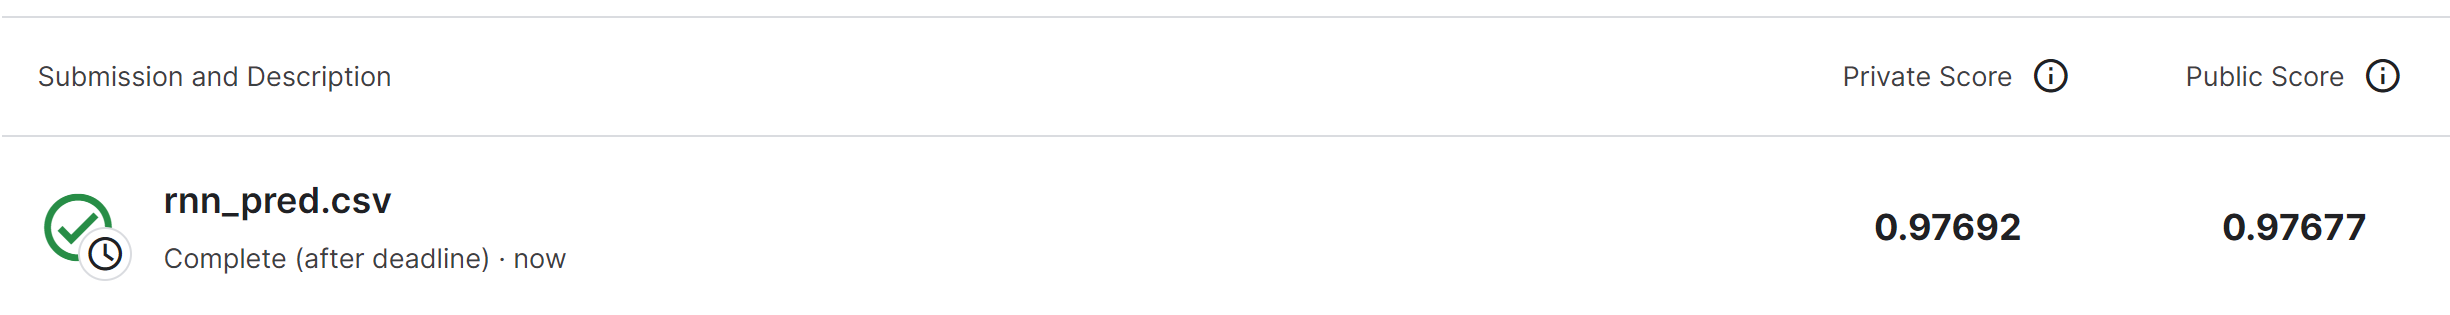

In [43]:
# classification report
rnn_pred_prob_val = model_opt.predict(X_val_seq_padded)
rnn_pred_val = (rnn_pred_prob_val > 0.5).astype(int)
print(classification_report(y_val, rnn_pred_val, target_names = labels))

998/998 [==============================] - 48s 48ms/step
               precision    recall  f1-score   support

        toxic       0.81      0.79      0.80      3059
 severe_toxic       0.55      0.33      0.41       319
      obscene       0.82      0.80      0.81      1690
       threat       0.48      0.30      0.37        96
       insult       0.73      0.72      0.73      1575
identity_hate       0.63      0.46      0.53       281

    micro avg       0.78      0.74      0.76      7020
    macro avg       0.67      0.57      0.61      7020
 weighted avg       0.77      0.74      0.75      7020
  samples avg       0.07      0.07      0.07      7020



The optimized bidirectional RNN consists of an embedding layer, a bidirectional RNN layer with 130 GRU units, a dropout layer and an output layer. The loss function is minimized with Adam optimizer and the model is trained with a learning rate of 0.000129 and 128 epochs. Regarding the model performance, the predicted probabilities of six labels on test set gives an average AUC score around 0.97 which is close to the value of the same metric evaluated on validation set and slightly lower than that of training set. This result shows no evidence on overfitting or underfitting, and test set is equally challenging to our optimized model compared with the validation set. By analyzing the classification report, it can be seen that toxic, obscene and insult has a relatively higher and decent precision, recall and F1 score than the other three classes. One possible reason is that there exist far more comments tagged with these classes for the model to learn their characteristics. Depending on the purpose of text classification, the model can be tuned toward the highest possible value of above three metrics as well. Besides, the threshold is selected as 0.5 and it's possible for the model to have a better performance at some other choices of threshold. In reality, the choice of threshold varies among different industries, and this often need the advice from domain experts, but this is beyond the scope of this study.

## Discussion

This study explored the application of different RNN architectures including LSTM/GRU, Bidirectional RNN and stacked RNN on multi-label text classification problem. Models are trained with a weighted loss function to handle class imbalance issue and their performance are compared with each other to study their advantages and disadvantages. Overall, bidirectional RNN has a better performance than regular RNN and RNN with GRU units is less time-consuming on training process than their LSTM counterparts. However, there is a trade-off between model performance and training efficiency for bidirectional RNN. Depending on the specific tasks and the expectation, data scientists need to decide whether or not to design a bidirectional RNN. Stacked RNN theoretically has a better performance than the regular RNN since it allows the RNN to learn more complex representations of the text data. Nonetheless, it doesn't have a clear performance gap compared with other RNN architectures in this study and one potential reason is that the validation data is not challenging enough to leverage its full potential. The optimized model is selected with hyperparameter tuning technique, and the average AUC score is decent. There are some opportunities to further improve the final model. With greater amounts of resources, a wider range and choices of hyperparameter can be tuned to find a more optimized model with respect to the average AUC score. Training a deeper RNN can also be beneficial for improving model performance, for example, a stacked bidirectional GRU neural network. Beyond developing a deeper neural network, resampling technique can be leveraged to further handling the imbalance classes if enough resources are available. Oversampling minority classes is beneficial for achieving a higher precision, recall or F1 score on minority classes.